In [1]:
%matplotlib inline

In [2]:
import shapely as shape
import shapely.geometry as shapeg

import descartes as desc
#from shapely.geometry import Polygon
#from shapely.ops import cascaded_union
#from shapely.geometry import Point
#from descartes.patch import PolygonPatch
import IPython 
import numpy as np
from matplotlib import pyplot

In [3]:
#coordinates are taken from
#https://desi.lbl.gov/trac/browser/code/focalplane/positioner_control/trunk/anticollision/pos_geometry.m?rev=1660

In [16]:
def rot_displ_shape(shape_coords, angle=0.0, radius=0.0):
    """
    Angle must be in radians
    """
    tmp = shape_coords.copy()
    tmp[:,0] = shape_coords[:,0]*np.cos(np.deg2rad(angle)) - shape_coords[:,1]*np.sin(np.deg2rad(angle))
    tmp[:,1] = shape_coords[:,0]*np.sin(np.deg2rad(angle)) + shape_coords[:,1]*np.cos(np.deg2rad(angle))
    tmp[:,0] = tmp[:,0] + radius*np.cos(np.deg2rad(angle))
    tmp[:,1] = tmp[:,1] + radius*np.sin(np.deg2rad(angle))
    return tmp

class positioner(object):
    def __init__(self, offset_x = 0.0, offset_y=0.0, Theta=0.0, Phi=0.0):
        self.offset_x = offset_x
        self.offset_y = offset_y
        self.ferrule_radius = 1.250/2.0
        self.R1 = 3.000 # distance from central axis to eccentric axis
        self.R2 = 3.000 # distance from eccentric axis to ferrule axis
        self.Ei = 6.800 # inner clear rotation envelope
        self.Eo = 9.990 # outer clear rotation envelope
        self.Theta = Theta
        self.Phi = Phi
        
        #basic setup
        self.lower_pos = np.array(((0.387, 0.990), (0.967,0.410), (0.967, -0.410), (0.387, -0.990), (-0.649, -0.990), 
                    (-1.000, -0.639), (-1.000, 0.639), (-0.649, 0.990)))
        self.lower_pos[:,0]=self.lower_pos[:,0] + self.R1 
        self.lower_pos[:,1]=self.lower_pos[:,1] 
        
        self.upper_pos = np.array(((0.387, -0.990), (0.967, -0.410), (0.967,0.410), (0.387,0.990), (-2.235,0.990), 
                   (-2.668, 1.240), (-3.514, 1.240), (-4.240,0.514), (-4.240,-0.514), (-3.682,-1.072), 
                  (-2.994,-1.339), (-2.944,-1.922), (-2.688, -2.015 ), (-1.981,-1.757 ), (-1.844, -0.990)))
        self.upper_pos[:,0]=self.upper_pos[:,0] + self.R1 
        self.upper_pos[:,1]=self.upper_pos[:,1] 
        
        self.central_pos = np.array((( 4.358 , -2.500), (5.095,-0.474),(5.095,0.605),(4.348,1.792), 
                    (3.000,2.180), (1.652, 1.792), (0.905, 0.605), (0.905 ,-0.356), 
                    (1.759, -2.792), (2.771, -2.500)))
        self.central_pos[:,0] = self.central_pos[:,0] 
        self.central_pos[:,1] = self.central_pos[:,1] 
        
        self.Eo_circ_resn  = 32;
        self.env_pos = np.zeros((self.Eo_circ_resn,2))
        self.env_pos[:,0] = self.Eo/2*np.cos(np.linspace(0,2*np.pi,self.Eo_circ_resn))
        self.env_pos[:,1] = self.Eo/2*np.sin(np.linspace(0,2*np.pi,self.Eo_circ_resn))
        
        #move to Theta and Phi
        #first rotate phi
        self.upper_pos = rot_displ_shape(self.upper_pos, angle=self.Phi) 
        self.lower_pos = rot_displ_shape(self.lower_pos, angle=self.Phi)
        #offset the central axis 
        self.upper_pos = rot_displ_shape(self.upper_pos, angle=0, radius=self.R1)
        self.lower_pos = rot_displ_shape(self.lower_pos, angle=0, radius=self.R1)

        #now rotathe theta
        self.upper_pos = rot_displ_shape(self.upper_pos, angle=self.Theta) 
        self.lower_pos = rot_displ_shape(self.lower_pos, angle=self.Theta)
        self.central_pos = rot_displ_shape(self.central_pos, angle=self.Theta)
        
        
        #final offset
        self.upper_pos[:,0]=self.upper_pos[:,0] + self.offset_x
        self.upper_pos[:,1]=self.upper_pos[:,1] + self.offset_y
        self.central_pos[:,0]=self.central_pos[:,0] + self.offset_x
        self.central_pos[:,1]=self.central_pos[:,1] + self.offset_y
        self.lower_pos[:,0]=self.lower_pos[:,0] + self.offset_x
        self.lower_pos[:,1]=self.lower_pos[:,1] + self.offset_y
        self.env_pos[:,0]=self.env_pos[:,0] + self.offset_x
        self.env_pos[:,1]=self.env_pos[:,1] + self.offset_y

In [17]:
def add_plot_positioner(positioner, ax=None): 
    up_poly = shapeg.Polygon(positioner.upper_pos)
    central_poly= shapeg.Polygon(positioner.central_pos)
    low_poly= shapeg.Polygon(positioner.lower_pos)
    env_poly = shapeg.Polygon(positioner.env_pos)
    
    patch_u = desc.patch.PolygonPatch(up_poly, facecolor='yellow', edgecolor='yellow', alpha=0.5, zorder=2)
    patch_c = desc.patch.PolygonPatch(central_poly, facecolor='blue', edgecolor='blue', alpha=0.5, zorder=2)
    patch_l = desc.patch.PolygonPatch(low_poly, facecolor='red', edgecolor='red', alpha=0.5, zorder=2)
    patch_e = desc.patch.PolygonPatch(env_poly, facecolor='white', edgecolor='black', alpha=0.2, zorder=2)

    ax.add_patch(patch_e)
    ax.add_patch(patch_u)
    ax.add_patch(patch_c)
    ax.add_patch(patch_l)

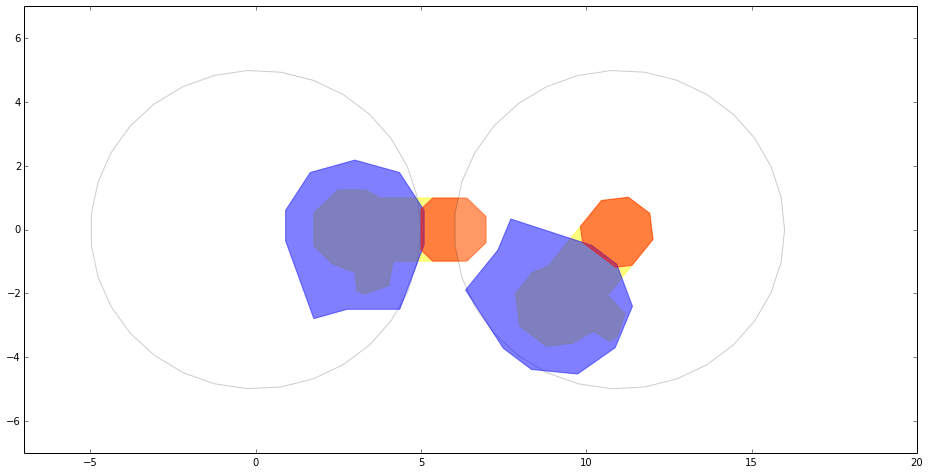

In [26]:
fig, ax = pyplot.subplots(figsize=(16, 8))
ax.set_xlim(-7,20)
ax.set_ylim(-7,7)
T = -128.0 #theta
P = +180.0 #phi
pos_A = positioner(Theta=0, Phi=0)
pos_B = positioner(Theta=-128, Phi=+180.0, offset_x=11.0)
add_plot_positioner(pos_A, ax=ax)
add_plot_positioner(pos_B, ax=ax)